Controle clássico para um Guindaste Hidráulico Florestal

In [1]:
# Operações com matrizes e vetores:
import numpy as np
import sympy as sp
import control as co_general
import control.matlab as co
import matplotlib.pyplot as plt


 - Declaração das FTs que serão usadas

In [2]:
# Simbolos utilizados:
s = co.tf('s')

In [57]:
# Função de transferência do sistema em malha aberta:
dem = s**6 + 0.02774*s**5 + 26.03*s**4 + 0.1328*s**3 + 30.03*s**2 - 0.1616*s - 120
num = -0.0002981*s**4 - 7.27e-07*s**3 - 0.001487*s**2 + 4.095e-07*s + 0.0009274
G = num/dem
 
print(G)


-0.0002981 s^4 - 7.27e-07 s^3 - 0.001487 s^2 + 4.095e-07 s + 0.0009274
-----------------------------------------------------------------------
s^6 + 0.02774 s^5 + 26.03 s^4 + 0.1328 s^3 + 30.03 s^2 - 0.1616 s - 120



- Identificando os polos do sistema em malha aberta

[-0.01181462+4.96099788j -0.01181462-4.96099788j -0.00154511+1.74020406j
 -0.00154511-1.74020406j -1.26938876+0.j          1.26836822+0.j        ]
[-0.00121991+2.35561333j -0.00121991-2.35561333j  0.74877063+0.j
 -0.74876958+0.j        ]


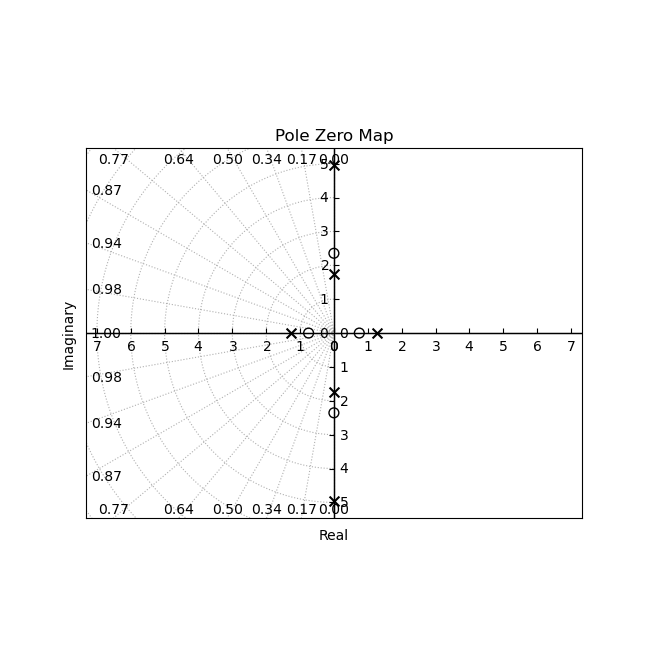

In [58]:
polos = co.pole(G)
zeros = co.zero(G)
co.pzmap(G, plot=True, grid=True, title='Pole Zero Map')


print(polos)
print(zeros)

- Calcula a estabilidade do sistema em malha aberta

In [59]:
# Verificando as condições de Routh-Hurwitz
# Script para verificar as condições de Routh-Hurwitz será disponibilizado em SCILAB
condicoes_estabilidade = np.all(np.real(polos) < 0)

if condicoes_estabilidade:
    print("O sistema é estável pelo critério de Routh-Hurwitz.")
else:
    print("O sistema é instável pelo critério de Routh-Hurwitz.")

O sistema é instável pelo critério de Routh-Hurwitz.


(array([7.83257035e-06, 7.83401714e-06, 7.83548395e-06, 7.83697105e-06,
        7.83847872e-06, 7.84000724e-06, 7.84155690e-06, 7.84312798e-06,
        7.84472079e-06, 7.84633562e-06, 7.84797277e-06, 7.84963256e-06,
        7.85131528e-06, 7.85302126e-06, 7.85475081e-06, 7.85650425e-06,
        7.85828192e-06, 7.86008415e-06, 7.86191127e-06, 7.86376362e-06,
        7.86564156e-06, 7.86754542e-06, 7.86947557e-06, 7.87143236e-06,
        7.87341616e-06, 7.87542734e-06, 7.87746627e-06, 7.87953333e-06,
        7.88162891e-06, 7.88375340e-06, 7.88590719e-06, 7.88809068e-06,
        7.89030428e-06, 7.89254840e-06, 7.89482346e-06, 7.89712987e-06,
        7.89946806e-06, 7.90183848e-06, 7.90424155e-06, 7.90667773e-06,
        7.90914746e-06, 7.91165120e-06, 7.91418942e-06, 7.91676258e-06,
        7.91937116e-06, 7.92201564e-06, 7.92469652e-06, 7.92741427e-06,
        7.93016942e-06, 7.93296245e-06, 7.93579390e-06, 7.93866428e-06,
        7.94157412e-06, 7.94452395e-06, 7.94751432e-06, 7.950545

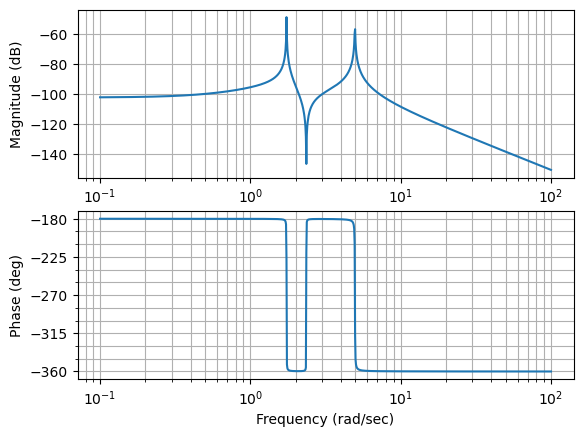

In [60]:
co.bode(G)

(array([-7.72833333e-06, -7.72833377e-06, -7.72833508e-06, ...,
         3.12170288e-10,  3.05057240e-10,  2.98106272e-10]),
 array([-0.00000000e+00,  1.42754888e-12,  2.85509851e-12, ...,
         8.08264316e-15,  7.80796641e-15,  7.54262434e-15]),
 array([0.00000000e+00, 2.04081633e-04, 4.08163265e-04, ...,
        9.77214697e+02, 9.88541702e+02, 1.00000000e+03]))

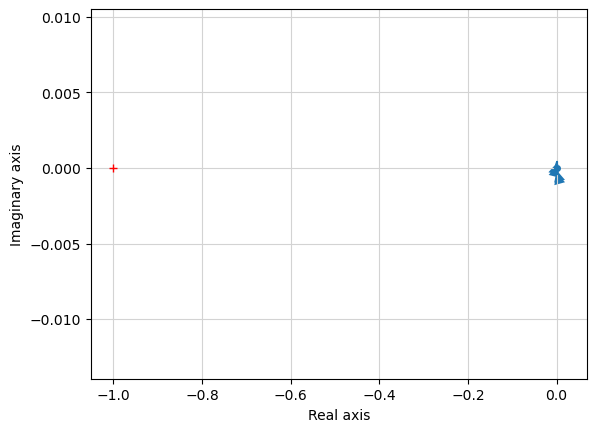

In [61]:
co.nyquist(G)

- Resposta do sistema em malha aberta a uma entrada degrau

/Users/guilhermepifferchristo/anaconda3/lib/python3.10/site-packages/control/timeresp.py:1054: RuntimeWarning: overflow encountered in matmul
  xout[:, i] = (Ad @ xout[:, i-1]
/Users/guilhermepifferchristo/anaconda3/lib/python3.10/site-packages/control/timeresp.py:1054: RuntimeWarning: invalid value encountered in matmul
  xout[:, i] = (Ad @ xout[:, i-1]


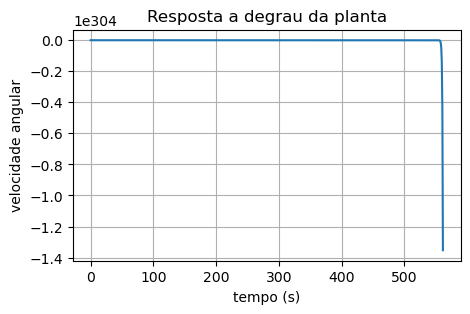

In [62]:
# Resposta a degrau da planta
plt.figure(2, figsize=(5,3))
omegao, t = co.step(G)
plt.plot(t,omegao)
plt.title('Resposta a degrau da planta')
plt.xlabel('tempo (s)')
plt.ylabel('velocidade angular')
plt.grid()

Ziegler-Nichols'

In [72]:
def pid_ziegler_nichols(g):
    _, y = co_general.step_response(g)

    k = y[-1]
    print(k)
    t = co_general.step_info(g)['RiseTime']
    
    kp = 0.6 * k
    ki = 1.2 / t
    kd = 0.075 * t
    
    return kp, ki, kd

In [73]:
# Calcular os parâmetros do controlador PID usando Ziegler-Nichols
kp, ki, kd = pid_ziegler_nichols(G)

# Exibir os parâmetros do controlador PID
print("Parâmetros do Controlador PID:")
print("Kp =", kp)
print("Ki =", ki)
print("Kd =", kd)

nan
Parâmetros do Controlador PID:
Kp = nan
Ki = inf
Kd = 0.0


/Users/guilhermepifferchristo/anaconda3/lib/python3.10/site-packages/control/timeresp.py:1054: RuntimeWarning: overflow encountered in matmul
  xout[:, i] = (Ad @ xout[:, i-1]
/Users/guilhermepifferchristo/anaconda3/lib/python3.10/site-packages/control/timeresp.py:1054: RuntimeWarning: invalid value encountered in matmul
  xout[:, i] = (Ad @ xout[:, i-1]
/Users/guilhermepifferchristo/anaconda3/lib/python3.10/site-packages/control/timeresp.py:1565: RuntimeWarning: overflow encountered in divide
  np.abs(yout/InfValue-1) >= SettlingTimeThreshold)[0][-1]+1
/var/folders/60/nj67kb651dlb556srctrpq800000gn/T/ipykernel_57683/1745235810.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  ki = 1.2 / t


- Alocação de polos

In [69]:
# Converter a função de transferência em espaço de estados
sys_ss = co_general.tf2ss(G)

# Definir os polos desejados
polos_desejados = [-2, -3, -1, -0.5, -0.25, -0.1]

# Realizar a alocação de polos
K = co_general.place(sys_ss.A, sys_ss.B, polos_desejados)

# Exibir a matriz de ganhos do controlador
print("Matriz de ganhos do controlador:")
print(K)


Matriz de ganhos do controlador:
[[  6.82226  -9.73     16.4297  -22.655     1.4991  120.075  ]]


- Controle Ótimo ITAE

In [74]:
def itae_cost(x, G):
    Kp = x
    Ki = x
    Kd = x
    C = co_general.tf([Kd, Kp, Ki], [1, 0])
    L = co_general.series(C, G)
    T = co_general.feedback(L, 1)
    t, y = co_general.step_response(T)
    e = 1 - y
    cost = sum(t * abs(e))
    return cost

In [81]:
from scipy.optimize import minimize_scalar

# Encontrar os ganhos ótimos que minimizam o custo ITAE
result = minimize_scalar(itae_cost, args=(G,), bounds=(0, 10), method='bounded')

# Obter o ganho ótimo
K_opt = result.x

# Criar o controlador PID ótimo
C = co_general.tf([0.6 * K_opt, 1.2 / K_opt, 0.075 * K_opt], [1, 0])

# Exibir os ganhos ótimos
print("Ganhos ótimos:")
print("Kp =", 0.6 * K_opt)
print("Ki =", 1.2 / K_opt)
print("Kd =", 0.075 * K_opt)

# Exibir a função de transferência do controlador ótimo
print("Função de transferência do controlador ótimo:")
Gc = co_general.minreal(C)
print(Gc)

# Resposta a degrau da planta
plt.figure(2, figsize=(5,3))
omegao, t = co.step(Gc)
plt.plot(t,omegao)
plt.title('Resposta a degrau da planta')
plt.xlabel('tempo (s)')
plt.ylabel('velocidade angular')
plt.grid()

# Exibir o diagrama de Bode do controlador ótimo
plt.figure(3, figsize=(5,3))
co_general.bode(C, dB=True, Hz=True, deg=True, omega=np.logspace(-2, 2, 1000))

# Exibir o diagrama de Nyquist do controlador ótimo
plt.figure(4, figsize=(5,3))
co_general.nyquist(C)



/var/folders/60/nj67kb651dlb556srctrpq800000gn/T/ipykernel_57683/245879873.py:10: RuntimeWarning: overflow encountered in multiply
  cost = sum(t * abs(e))


Ganhos ótimos:
Kp = 2.2917960675006306
Ki = 0.3141640786499874
Kd = 0.2864745084375788
Função de transferência do controlador ótimo:
0 states have been removed from the model

2.292 s^2 + 0.3142 s + 0.2865
-----------------------------
              s

0 states have been removed from the model


ValueError: Transfer function is non-proper; can't convert to StateSpace system.

<Figure size 500x300 with 0 Axes>

- Lugar das raizes

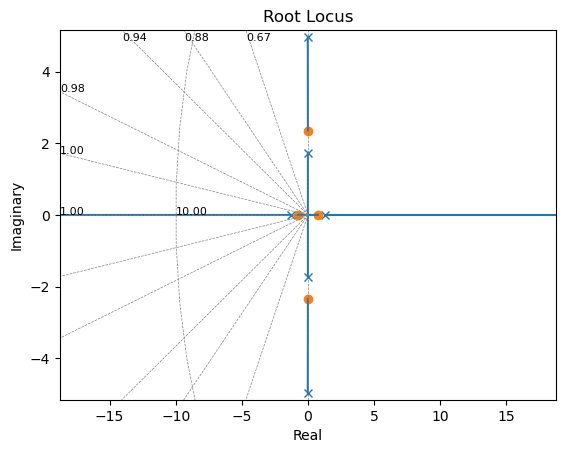

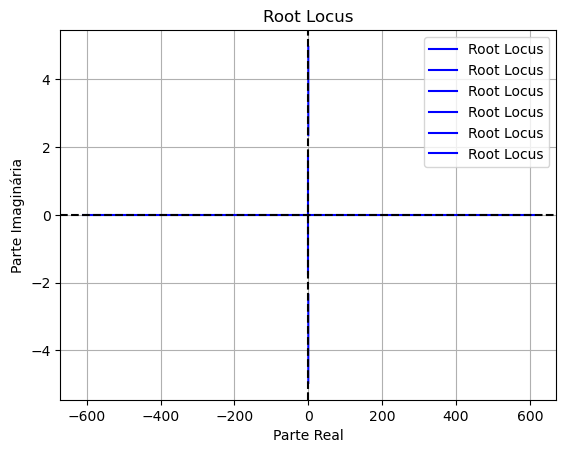

In [78]:
# Calcular o root locus
rlist, klist = co_general.root_locus(G)

# Plotar o root locus
plt.figure()
plt.plot(rlist.real, rlist.imag, "b", label="Root Locus")
plt.axhline(y=0, color="k", linestyle="--")
plt.axvline(x=0, color="k", linestyle="--")
plt.xlabel("Parte Real")
plt.ylabel("Parte Imaginária")
plt.title("Root Locus")
plt.grid(True)
plt.legend()
plt.show()